# Clustering of imaging data

In [1]:
import numpy as np                     # scientific computing toolkit
import pandas as pd                    # data analysis toolkit
import scanpy as sc                    # scanpy is referred to with sc.***
import matplotlib.pyplot as plt        # Matplotlib is referred to with plt.***
from sklearn import preprocessing      # Used for sillouette score
from scipy import stats
import seaborn as sns
import math
import matplotlib.colors as pltcolor

sc.settings.verbosity = 0              # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()            # check if all needed versions are installed and up to date

scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2 statsmodels==0.11.1 python-igraph==0.8.0


In [2]:
sc.settings.set_figure_params(dpi=80, dpi_save=200, color_map='viridis')

## Import and preprocessing:

#### Read the files for channels, FL_values and distances generated in ImageJ as pandas DataFrames:

In [3]:
data=pd.read_csv('./data/FL_values.csv',)
channels=pd.read_csv('./data/channels.csv')
gatings=pd.read_csv('./data/gatings.csv',sep=';')
gatings=gatings.fillna(0).astype(int)
gatings=gatings-1
gatings=gatings.astype(str)
cellnumber=int(data.shape[0]/channels.shape[0])

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Generate a matrix with the mean intensity values for each channel listed in additional columns and reshape the DataFrame:

In [4]:
matrix=pd.DataFrame(data[:cellnumber])
for i in range(0,channels.shape[0]):
    matrix[str(channels.iloc[i,0])]=0.000
    matrix[str(channels.iloc[i,0])][:cellnumber]=data.Mean[i*cellnumber:(i+1)*cellnumber]

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
#Drop columns which will not be used in the adata object and replace NaN with a 0
matrix.fillna(0,inplace=True)
matrix_new = matrix.drop(matrix.iloc[:, 0:35], axis=1)
matrix.rename(columns={'Circ.':'Circularity'}, inplace=True)
matrix_new = matrix_new[matrix_new.columns.drop(list(matrix_new.filter(regex='min_Dist')))]
matrix_normalized=matrix_new
matrix_normalized.index = pd.RangeIndex(len(matrix_normalized.index))

#Normalize the values within each marker 
for i in range(0,channels.shape[0]):
    df=matrix_new[str(channels.iloc[i,0])]
    matrix_normalized[str(channels.iloc[i,0])]=(df-df.min())/(df.max()-df.min())*100000

#export matrix to read in again as adata object
matrix_normalized.to_csv('./export/matrix.csv')

#### Read in matrix as scanpy object and save some variables from the initial matrix as adata.obs:

In [6]:
adata=sc.read_csv('./export/matrix.csv',first_column_names=True)
adata.obs['X']=matrix.X.values.tolist()
adata.obs['Y']=matrix.Y.values.tolist()
adata.obs['area']=matrix.Area.values.tolist()
adata.obs['circularity']=matrix.Circularity.values.tolist()
adata.obs['Annotation']='Dirt'
adata.obs['Gated_population_1']='not_gated'
adata.obs['Gated_population_2']='not_gated'

#### Import gatings if provided:

In [7]:
pd.set_option('mode.chained_assignment', None)
adata.obs.Annotation[adata.obs_names.isin(gatings.Area_1)]='Area_1'
adata.obs.Annotation[adata.obs_names.isin(gatings.Area_2)]='Area_2'
adata.obs.Annotation[adata.obs_names.isin(gatings.Dirt)]='Dirt'

In [8]:
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.LP)]='Lamina propria'
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.lymphocytes)]='Lymphocytes'
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.epithelial)]='Epithelial cells'
adata.obs.Gated_population_1[adata.obs_names.isin(gatings.muscular)]='Muscular cells'

In [9]:
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.B_cells_2)]='B cells'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.T_cells_2)]='T cells'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.Macrophages_2)]='Macrophages'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.Monocytes_2)]='Monocytes'
adata.obs.Gated_population_2[adata.obs_names.isin(gatings.Tregs)]='Tregs'

In [10]:
sc.pp.filter_cells(adata, min_genes=3)

#### Check for markers with the highest expression over the tissue:

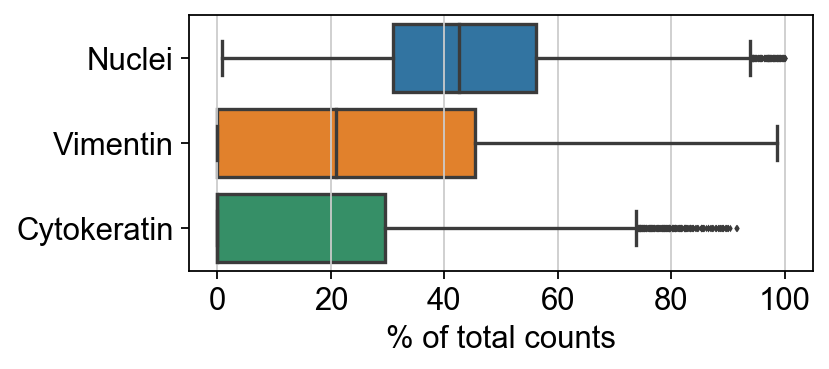

In [11]:
sc.pl.highest_expr_genes(adata, n_top=3)

#### Filter cells according to theire total brighness, area and circularity and process values for further analysis:

... storing 'Annotation' as categorical
... storing 'Gated_population_1' as categorical
... storing 'Gated_population_2' as categorical


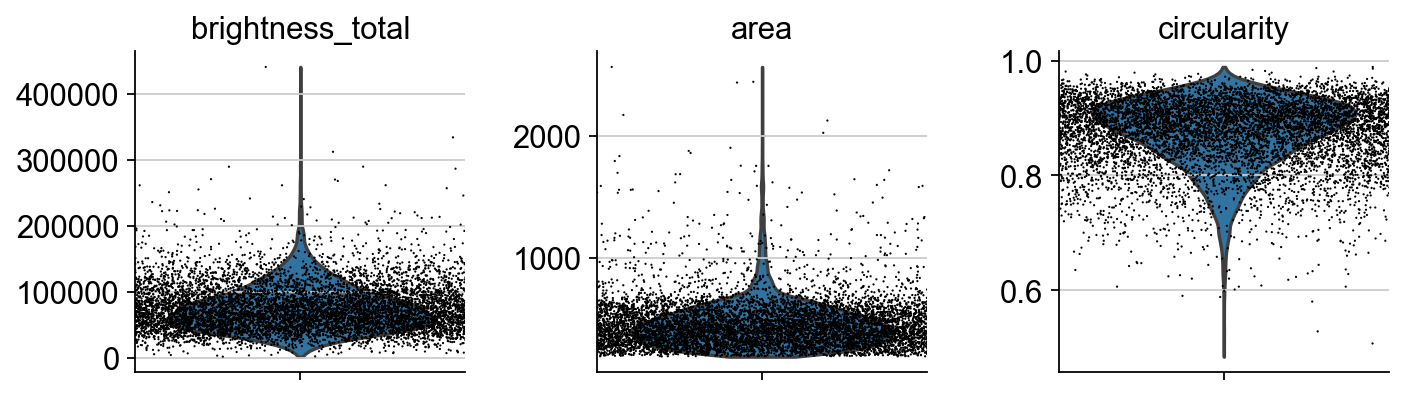

In [12]:
adata.obs['brightness_total'] = adata.X.sum(axis=1)
sc.pl.violin(adata, ['brightness_total','area','circularity'], jitter=0.8, multi_panel=True)

In [13]:
adata = adata[adata.obs['brightness_total'] < 200000, :]
adata = adata[adata.obs['area'] < 800, :]
adata = adata[adata.obs['circularity'] > 0.75, :]

In [14]:
var_data=pd.DataFrame(adata.X) #save var data for later merging with neighborhood matrix

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

/Users/Sebastian/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Generate distance matrix

In [16]:
calculate=False #Needs to be true to calculate the distances the first time. Set to false afterwards in order to save time

In [ ]:
if calculate == True:
    distances=np.empty([len(adata.obs_names),len(adata.obs_names)])
    x_values=adata.obs.X
    y_values=adata.obs.Y
    for j in range (distances.shape[0]):
        distances[j,j:] = ((x_values[j:].apply(lambda x: (x-x_values[j])**2))+(y_values[j:].apply(lambda y: (y-y_values[j])**2)))**(.5)
        print("Progress: {:2.1%}".format(j/distances.shape[0]), end="\r")

In [ ]:
# Make the matrix symetric
if calculate == True:
    arr = distances
    arr2 = np.triu(arr) + np.triu(arr,1).T
    distances_completed=pd.DataFrame(arr2)
    distances_completed.columns=adata.obs_names
    distances_completed.index=adata.obs_names
    distances_completed.to_csv('./export/distances_completed.csv')

In [ ]:
distances_completed = pd.read_csv('./export/distances_completed.csv',index_col=0)

In [ ]:
plt.imshow(distances_completed.astype(float), zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

# Visualisation and Dimensional reduction

#### Plot cells and check if the tissue architechture is preserved, or if too many cells have been filtered out:

In [ ]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 3), sharey=True)

ax1, ax2, ax3, ax4 = axes
sc.pl.scatter(adata, 'X', 'Y', color='Cytokeratin', color_map='viridis', ax=ax1, show=False, size=15)
sc.pl.scatter(adata, 'X', 'Y', color='Vimentin', color_map='viridis', ax=ax2, show=False, size=15)
sc.pl.scatter(adata, 'X', 'Y', color='SMA', color_map='viridis', ax=ax3, show=False, size=15)
sc.pl.scatter(adata, 'X', 'Y', color='CD45', color_map='viridis', ax=ax4, show=False, size=15)
fig.delaxes(fig.axes[4]) 
fig.show()

#### Run PCA, neighborhood embedding, UMAP and leiden clustering:

In [ ]:
sc.tl.pca(adata)

In [ ]:
sc.pl.pca_variance_ratio(adata)

In [ ]:
from sklearn.metrics import silhouette_score
def titrate_leiden_resolution(adata):
    res_array=list(np.round(np.linspace(.1, 2, 20),1))
    silhoutte_list=list()
    sc.settings.verbosity = 1
    for i,res in enumerate(res_array):
        sc.tl.leiden(adata, resolution=res)
        if adata.obs.leiden.unique().shape[0]>2:
            silhoutte_list.append(silhouette_score(adata.obsm['X_umap'],
                    adata.obs[f'leiden'],
                    metric='euclidean'))
        else:
            silhoutte_list.append(np.nan)
        print(str(np.round(((i+1)/len(res_array))*100,1))+"%", end="\r", flush=True)
    sns.lineplot(res_array, silhoutte_list, marker='o', color='black')
    print(silhoutte_list)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=7)
sc.tl.umap(adata, min_dist=1.7)

In [ ]:
titrate_leiden_resolution(adata)

In [ ]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata, color=['Gated_population_1', 'leiden'], ncols=2, legend_loc='on data')

#### Analyze and plot marker genes to annotate cell populations:
(for more ways of analyzing marker genes have a look at the scanpy documentation)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3)

In [ ]:
sc.pl.umap(adata, color=adata.var_names[~adata.var_names.isin(['Cytokeratin','Vimentin','SMA','Nuclei'])],
           ncols=5, s=25, save='markers.pdf')

In [ ]:
adata=adata[adata.obs.leiden!='17']

#### Annotate clusters and change colors for cell populations:

In [ ]:
pd.set_option('mode.chained_assignment', None)
adata.obs['celltype_Level_1']='undefined'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['7','5','6','15'])]='Epithelial cells'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['0','13'])]='muscular cells'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['1','2','8'])]='Lamina propria cells'
adata.obs.celltype_Level_1[adata.obs.leiden.isin(['14','10','4','3','12','11','9','19','16','18'])]='Lymphocytes'

In [ ]:
adata.obs['celltype_epithelial']='non-epithelial cells'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['16'])]='intraepithelial Lymphocytes'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['5','7'])]='Ki67 high epithelial'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['15'])]='GATA3+ epithelial'
adata.obs.celltype_epithelial[adata.obs.leiden.isin(['6'])]='Ki67 low epithelial'

In [ ]:
adata.obs['celltype_muscular']='non-muscular cells'
adata.obs.celltype_muscular[adata.obs.leiden.isin(['0','13'])]='muscular cells'

In [ ]:
adata.obs['celltype_lymphocytes']='CD45- cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['16'])]='intraepithelial Lymphocytes'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['12'])]='CD8 T cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['10'])]='CD4 T cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['14'])]='Monocytes'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['11'])]='Macrophages'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['19'])]='B cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['18'])]='PD-L1+ cells'
adata.obs.celltype_lymphocytes[adata.obs.leiden.isin(['4','3','9'])]='other Lymphocytes'

In [ ]:
adata.obs['celltype_Level_2']='not specified'

In [ ]:
adata.obs.celltype_Level_2[adata.obs.celltype_epithelial != 'non-epithelial cells']=adata.obs.celltype_epithelial
adata.obs.celltype_Level_2[adata.obs.celltype_muscular != 'non-muscular cells']=adata.obs.celltype_muscular
adata.obs.celltype_Level_2[adata.obs.celltype_lymphocytes != 'CD45- cells']=adata.obs.celltype_lymphocytes
adata.obs.celltype_Level_2[adata.obs.leiden.isin(['1','2','8'])]='Lamina propria cells'

In [ ]:
adata.uns['celltype_epithelial_colors']=['#1f77b4','#ff7f0e','#279e68','#d62728','#aa40fc','#d1d1d1']
adata.uns['celltype_muscular_colors']=['#1f77b4', '#ff7f0e', '#d1d1d1']
adata.uns['celltype_Level_2_colors']=['#1f77b4','#b41f1f','#b4821f','#279e68','#c4d627','#aa40fc','#8c564b','#e377c2','#b5bd61','#0b7510','#750b0b','#9edae5','#dbdb8d']
adata.uns['celltype_lymphocytes_colors']=['#1f77b4','#b41f1f','#b4821f','#d1d1d1','#279e68','#c4d627','#aa40fc','#8c564b','#e377c2','#b5bd61','#130b75','#0b6a75']
adata.uns['Gated_population_2_colors']=['#1f77b4','#279e68','#c4d627','#d62728','#aa40fc','#d1d1d1']
adata.uns['Gated_population_1_colors']=['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#d1d1d1']

In [ ]:
sc.pl.umap(adata, color=['leiden','celltype_Level_2','celltype_Level_1'], legend_loc="on data", legend_fontsize=6, frameon=False, ncols=3)

# Generate neighborhood data from distances

#### Plot the neighborhood of selected cells:

In [ ]:
cells_of_interest = ['9395','2397','2609','13019','2006','218','902','3974'] #cells selected from different tissue regions
x=60 #set the radius (represents a 30µm range)

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(18, 8))
fig.tight_layout(w_pad=5)
for i, cell in enumerate(cells_of_interest):
    ax.reshape(-1)[i].set_xlim([adata.obs.loc[cell]['X']-2.2*x,adata.obs.loc[cell]['X']+2.2*x])
    ax.reshape(-1)[i].set_ylim([adata.obs.loc[cell]['Y']-2.2*x,adata.obs.loc[cell]['Y']+2.2*x])
    circle = plt.Circle((adata.obs.loc[cell]['X'], adata.obs.loc[cell]['Y']), x, edgecolor="black", facecolor='none')
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed.loc[distances_completed[cell]<=(2*x),cell].index.values.astype(str))], 'X', 'Y', size=1500, alpha=0.5, ax=ax.reshape(-1)[i], show=False)
    sc.pl.scatter(adata[adata.obs_names.isin(distances_completed.loc[distances_completed[cell]<=x,cell].index.values.astype(str))], 'X', 'Y', color='celltype_Level_2', size=1500, ax=ax.reshape(-1)[i], show=False)
    sc.pl.scatter(adata[adata.obs_names.isin([cell])], 'X', 'Y', size=4000, ax=ax.reshape(-1)[i], show=False)
    ax.reshape(-1)[i].add_artist(circle)
    ax.reshape(-1)[i].grid(False)
    ax.reshape(-1)[i].get_legend().remove()
fig.savefig('./figures/cellsofinterest.svg')

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
sc.pl.scatter(adata, 'X', 'Y', color='celltype_Level_1', title='', alpha=0.6, size=40, ax=ax, show=False)
for cell in cells_of_interest:
    rectangle=plt.Rectangle((adata.obs.loc[cell]['X']-2.2*x, adata.obs.loc[cell]['Y']-2.2*x), x*4.4, x*4.4, edgecolor='black', facecolor='none')
    circle = plt.Circle((adata.obs.loc[cell]['X'], adata.obs.loc[cell]['Y']), 30, edgecolor="none", facecolor='black')
    ax.add_artist(circle)
    ax.add_artist(rectangle)
ax.grid(False)

#### Generate the environment matrix:

In [ ]:
distances_completed_na=distances_completed.replace(0,np.nan) #cells shouldnt be counted as their own neighbors
distances_completed_na[distances_completed_na>=x]=np.nan #exclude distances greater than the selected radius x

In [ ]:
neighbours=pd.DataFrame()
for i in range(adata.obs.celltype_Level_2.nunique()):
    neighbours[i]=distances_completed_na.loc[:,adata.obs_names[adata.obs.celltype_Level_2==np.sort(adata.obs.celltype_Level_2.unique()).astype(str)[i]].values].count(axis=1)

In [ ]:
for i, cluster in enumerate(adata.obs.celltype_Level_2.unique()):
    neighbours.iloc[:,i]=neighbours.iloc[:,i]/(adata[adata.obs.celltype_Level_2==cluster].shape[0]/adata.shape[0])

In [ ]:
neighbours.columns=np.sort(adata.obs.celltype_Level_2.unique()).astype(str)

In [ ]:
#for cell in neighbours.index.astype(str).tolist():
#    phenotype=adata.obs.loc[cell].celltype_Level_2
#    neighbours.loc[int(cell),neighbours.columns==phenotype]=0

In [ ]:
#Process and merge the adata.var matrix with the distance matrix
var_data.columns=adata.var_names
var_data.index=neighbours.index
neighbours.columns=np.sort(adata.obs.celltype_Level_2.unique()).astype(str)
var_data_merged=pd.concat([neighbours, var_data], axis=1)
var_data_merged=var_data_merged[var_data_merged.index.isin(adata.obs_names)]
var_data_merged.to_csv('./export/var_data_merged.csv', index=False)
adata_neigbours=sc.read_csv('./export/var_data_merged.csv')
sc.pp.normalize_total(adata_neigbours, target_sum=1e4)
sc.pp.log1p(adata_neigbours)
sc.pp.scale(adata_neigbours, max_value=10)
adata_neigbours.obs=adata.obs
adata_neigbours.uns=adata.uns
adata_neigbours.var['feature_types']='gene_expression'
adata_neigbours.var['feature_types'][:adata_neigbours.obs.celltype_Level_2.nunique()]='distance'

# Cluster neighborhood matrix

In [ ]:
adata_neigbours_only=adata_neigbours[:,adata_neigbours.var.feature_types=='distance']
adata_neigbours_only.obs['n_counts'] = adata_neigbours_only.X.sum(axis=1)

In [ ]:
sc.tl.pca(adata_neigbours_only, svd_solver='arpack')
sc.pp.neighbors(adata_neigbours_only, n_neighbors=50, n_pcs=5)
sc.tl.umap(adata_neigbours_only, min_dist=1.8)

In [ ]:
titrate_leiden_resolution(adata_neigbours_only)

In [ ]:
sc.tl.leiden(adata_neigbours_only, key_added='leiden_neighbours', resolution=0.4)
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2','leiden_neighbours'], legend_loc='on data', legend_fontsize=6, frameon=False, save='Clusters_micro.pdf')

In [ ]:
sc.pl.umap(adata_neigbours_only, color='leiden_neighbours', palette='coolwarm', legend_loc='on data', save='Micro.pdf')

In [ ]:
sc.pl.umap(adata_neigbours_only, color=adata_neigbours_only.var_names, ncols=5, size=25, save='names.pdf')

#### Plot random examples from selected neighborhood clusters:

In [ ]:
def plot_neighbours_2(cell, ax, defining_phenotype, show_only_defining=True):
    x=60
    ax.set_xlim([adata.obs.loc[cell]['X']-1.2*x,adata.obs.loc[cell]['X']+1.2*x])
    ax.set_ylim([adata.obs.loc[cell]['Y']-1.2*x,adata.obs.loc[cell]['Y']+1.2*x])
    plotdata=adata[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=x,cell].index.values.astype(str))]
    
    if show_only_defining==True:
        sc.pl.scatter(plotdata[plotdata.obs.celltype_Level_2.values.astype(str)==defining_phenotype], 'X', 'Y', color='celltype_Level_2', size=400, ax=ax, show=False)
        sc.pl.scatter(plotdata[plotdata.obs.celltype_Level_2.values.astype(str)!=defining_phenotype], 'X', 'Y', color='celltype_Level_2', size=400, ax=ax, alpha=0.3, show=False)
    else:
        sc.pl.scatter(plotdata, 'X', 'Y', color='celltype_Level_2', size=400, ax=ax, show=False)
    
    sc.pl.scatter(adata[adata.obs_names.isin([cell])], 'X', 'Y', size=800, color='celltype_Level_2', ax=ax, show=False)
    circle = plt.Circle((adata.obs.loc[cell]['X'], adata.obs.loc[cell]['Y']), 10, edgecolor="black", facecolor='none')
    ax.add_artist(circle)
    ax.grid(False)
    ax.get_legend().remove()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('')

In [ ]:
for j in [6,0,11,10,15]:
    print('Environment cluster '+str(j))
    fig, ax = plt.subplots(ncols=10,nrows=2, figsize=(20,4))
    i=0
    defining_phenotype=pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(j)].X, columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False).index[0]
    for cell in np.random.choice(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(j)].obs_names.values, size=20):
        plot_neighbours_2(cell, ax.reshape(-1)[i], defining_phenotype)
        i=i+1
    plt.show()
    fig.savefig('./figures/cluster_'+str(j)+'.svg')

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,2))
for i,j in enumerate([6,0,11,10,15]):
    df=pd.DataFrame()
    for cell in adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(j)].obs_names.values:
        data=pd.DataFrame(adata.obs[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=(2*x),cell].index.values.astype(str))]["celltype_Level_2"].value_counts())
        data=data/data[data['celltype_Level_2']>0].sum()
        df=pd.concat([df,data], axis=1)
    
    data_all=pd.DataFrame(df.mean(axis=1), columns=['value'])
    data_all['color']=adata.uns['celltype_Level_2_colors']
    data_all=data_all.sort_values('value', ascending=False)
    ax[i].pie(data_all.value, colors=data_all.color)
    ax[i].set_title('Cluster '+str(j))

fig.savefig('./figures/pie_clusters.svg')
plt.show()

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# get colormap
ncolors = 256
color_array = plt.get_cmap('viridis')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='Viridis_alpha',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

In [ ]:
fig, ax=plt.subplots(ncols=2, figsize=(30,8))
sc.pl.umap(adata_neigbours_only, color='GATA3+ epithelial', frameon=False, ax=ax[0], size=100, show=False, color_map='viridis')
for color in adata_neigbours_only.var_names[adata_neigbours_only.var_names.str.contains('epithelial')]:
    sc.pl.umap(adata_neigbours_only, color=color, frameon=False, ax=ax[0], show=False, size=100, vmax=3, color_map='Viridis_alpha')
    fig.delaxes(fig.axes[3]) 
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2'], groups='intraepithelial Lymphocytes', ax=ax[1], size=100, show=False, frameon=False)
ax[0].set_title('merged epithelial cell neighbors')
plt.show()

In [ ]:
def calculate_neighbors_members(adata, adata_all, clustering, celltypes, alternative_member_celltypes=None):
    df_all=pd.DataFrame()
    for i, j in enumerate(adata.obs[clustering].unique()):
        df=pd.DataFrame()
        for cell in adata[adata.obs[clustering]==str(j)].obs_names.values:
            data=pd.DataFrame(adata_all.obs[adata_all.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=(2*x),cell].index.values.astype(str))][celltypes].value_counts())
            data=data/data[data[celltypes]>0].sum()
            df=pd.concat([df,data], axis=1)
        df_all=pd.concat([df_all,pd.DataFrame(df.mean(axis=1),columns=[str(j)])], axis=1)
    df_all=df_all.T
    
    for i, cluster in enumerate(adata.obs[celltypes].unique()):
        df_all.iloc[:,i]=df_all.iloc[:,i]/(adata_all[adata_all.obs[celltypes]==cluster].shape[0]/adata_all.shape[0])

    simpson_list=[]
    for i in range(df_all.shape[0]):
        simpson_list.append(sum(n**2 for n in df_all.iloc[i]))

    df_all.columns=df_all.columns.astype(str)
    df_all['Diversity']=simpson_list
    df_all=df_all.sort_values('Diversity', ascending=False)

    if alternative_member_celltypes!=None:
        celltypes=alternative_member_celltypes
    
    df_members=pd.DataFrame()
    for i, j in enumerate(df_all.index.values.tolist()):
        data=adata_all.obs[adata_all.obs_names.isin(adata[adata.obs[clustering]==str(j)].obs_names.values)][celltypes].value_counts(normalize=True)
        df_members=pd.concat([df_members,data], axis=1)   
    df_members.columns=df_all.index.values.tolist()
    df_members=df_members.T
    return (df_all, df_members)

In [ ]:
df_all, df_members=calculate_neighbors_members(adata_neigbours_only, adata, "leiden_neighbours", "celltype_Level_2")

In [ ]:
df_members['epithelial']=df_members['Ki67 low epithelial']+df_members['Ki67 high epithelial']+df_members['GATA3+ epithelial']

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(10,10))
sns.barplot(x=df_members.index, y=df_members['epithelial'], color='#279e68', ax=ax[0], order=df_members.sort_values('epithelial', ascending=False).index)
sns.barplot(x=df_members.index, y=(df_members['Ki67 low epithelial']+df_members['Ki67 high epithelial']), color='#750b73', ax=ax[0], order=df_members.sort_values('epithelial', ascending=False).index)
sns.barplot(x=df_members.index, y=(df_members['Ki67 low epithelial']+df_members['Ki67 high epithelial']), color='#c4d627', ax=ax[0], order=df_members.sort_values('epithelial', ascending=False).index)
sns.barplot(x=df_members.index, y=df_members['Ki67 low epithelial'], color='#aa40fc', ax=ax[0], order=df_members.sort_values('epithelial', ascending=False).index)
sns.barplot(x=df_members.index, y=df_members['muscular cells'], color='#9edae5', ax=ax[1], order=df_members.sort_values('epithelial', ascending=False).index)
sns.barplot(x=df_members.index, y=(df_members['CD4 T cells']+df_members['CD8 T cells']), color='#b4821f', ax=ax[2], order=df_members.sort_values('epithelial', ascending=False).index)
sns.barplot(x=df_members.index, y=df_members['CD4 T cells'], color='#b41f1f', ax=ax[2], order=df_members.sort_values('epithelial', ascending=False).index)
sns.barplot(x=df_members.index, y=df_members['intraepithelial Lymphocytes'], color='#750b0b', ax=ax[3], order=df_members.sort_values('epithelial', ascending=False).index)
fig.savefig('./figures/barplots.svg')

In [ ]:
df_members=df_members.drop('epithelial', axis=1)

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(30,5))
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2'], title='PDL1+', legend_loc=None, groups='PD-L1+ cells', size=100, frameon=False, ax=ax[5], show=False)
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2'], title='B cells', legend_loc=None, groups='B cells', size=100, frameon=False, ax=ax[4], show=False)
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2'], title='intraepithelial Lymphocytes', legend_loc=None, groups='intraepithelial Lymphocytes', size=100, frameon=False, ax=ax[3], show=False)
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2'], title='Lamina propria cells', groups='Lamina propria cells', size=100, frameon=False, legend_loc=None, ax=ax[1], show=False)
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2'], title='T cells', groups=['CD4 T cells','CD8 T cells'], size=100, legend_loc=None, frameon=False, ax=ax[2], show=False)
sc.pl.umap(adata_neigbours_only, color=['celltype_Level_2'], title='epithelial cells', groups=['Ki67 high epithelial','Ki67 low epithelial','GATA3+ epithelial'], legend_loc=None, size=100, frameon=False, ax=ax[0], show=False)
fig.savefig('./figures/distribution.svg')

In [ ]:
CV_data=pd.concat([pd.DataFrame(df_members.std()/df_members.mean(), columns=['CV']), 
                   pd.DataFrame(adata_neigbours_only.uns['celltype_Level_2_colors'].tolist(), 
                                index=df_members.columns, columns=['color'])], axis=1)
CV_data=CV_data.sort_values('CV')

In [ ]:
ax=CV_data.plot(kind='barh', color=CV_data.color, legend=None, figsize=(5,10))
for i in range(CV_data.shape[0]):
    ax.get_children()[i].set_color(CV_data.color.values.tolist()[i])
plt.savefig('./figures/CV.pdf')

In [ ]:
defining_types_1=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False).index[0] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]
values_1=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False)[0] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]

In [ ]:
defining_types_2=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False).index[1] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]
values_2=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False)[1] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]

In [ ]:
defining_types_3=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False).index[2] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]
values_3=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False)[2] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]

In [ ]:
defining_types_4=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False).index[3] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]
values_4=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False)[3] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]

In [ ]:
defining_types_5=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False).index[4] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]
values_5=[pd.DataFrame(adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(x)].X, 
                             columns=adata_neigbours_only.var_names).mean().sort_values(ascending=False)[4] for x in range(adata_neigbours_only.obs.leiden_neighbours.nunique())]

In [ ]:
defining_df=pd.DataFrame([defining_types_1,values_1,defining_types_2,values_2,defining_types_3,values_3,defining_types_4,values_4,defining_types_5,values_5], 
             index=['type_1','value_1','type_2','value_2','type_3','value_3','type_4','value_4','type_5','value_5']).T

In [ ]:
defining_df_norm=defining_df.loc[:,['value_1','value_2','value_3','value_4','value_5']]

In [ ]:
defining_df_norm=defining_df_norm.div(defining_df_norm['value_1'], axis=0)

In [ ]:
defining_df_norm[defining_df.value_1<0]=0

In [ ]:
fig, ax = plt.subplots(nrows=14, figsize=(7,10), gridspec_kw={'height_ratios': [1.5,1,1,1,1,1,1,1,1,1,1,1,1,1]})
for i, pop in enumerate(CV_data.sort_values('CV',ascending=False).index):
    sns.barplot(x=df_members.index, y=df_members[pop], color=CV_data.sort_values('CV',ascending=False).color[i], 
                order=[str(i)for i in range(20)], ax=ax[i+1])
    ax[i+1].axes.get_xaxis().set_visible(False)
    ax[i+1].axes.get_yaxis().set_visible(False)
ax[-1].axes.get_xaxis().set_visible(True)
for i in range(defining_df.shape[0]):
    ax[0].plot([str(i)],[0],'o',ms=defining_df_norm.loc[i,'value_1']*14,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_1']].color)
    ax[0].plot([str(i)],[1],'o',ms=defining_df_norm.loc[i,'value_2']*14,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_2']].color)
    ax[0].plot([str(i)],[2],'o',ms=defining_df_norm.loc[i,'value_3']*14,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_3']].color)
    ax[0].axvline(x=i+0.5, ymin=0, ymax=2, color='gray')
ax[0].set_ylim(-0.6,2.5)
ax[0].set_xlim(-0.5,19.5)
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)
fig.savefig('./figures/distributions.svg')

In [ ]:
df=pd.DataFrame(index=adata.obs.celltype_Level_2.unique(), columns=adata.obs.celltype_Level_2.unique())

In [ ]:
for row in df.index.values.tolist():
    for column in df.columns.values.tolist():
        df_temp=distances_completed.loc[distances_completed.index.isin(adata.obs[adata.obs.celltype_Level_2==row].index.values.tolist()),
                       distances_completed.index.isin(adata.obs[adata.obs.celltype_Level_2==column].index.values.tolist())]
        df_temp[df_temp==0]=np.nan
        df.loc[row,column]=df_temp.min(skipna=True, axis=1).mean()

In [ ]:
df=df/2

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
ax=sns.heatmap(df.astype(float), cmap='viridis_r', square=True, vmax=100)
fig.savefig('./figures/mean_distances.pdf')

In [ ]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20,5))
for i in range(adata_neigbours_only.obs.leiden_neighbours.nunique()-1):
    df=pd.DataFrame()
    for cell in adata_neigbours_only[adata_neigbours_only.obs.leiden_neighbours==str(i)].obs_names.values:
        data=pd.DataFrame(adata.obs[adata.obs_names.isin(distances_completed_na.loc[distances_completed_na[cell]<=(2*x),cell].index.values.astype(str))]["celltype_Level_2"].value_counts())
        data=data/data[data['celltype_Level_2']>0].sum()
        df=pd.concat([df,data], axis=1)
    
    data_all=pd.DataFrame(df.mean(axis=1), columns=['value'])
    data_all['color']=adata.uns['celltype_Level_2_colors']
    data_all=data_all.sort_values('value', ascending=False)
    ax.reshape(-1)[i].pie(data_all.value, colors=data_all.color)
    ax.reshape(-1)[i].set_title('Cluster '+str(i))

fig.savefig('./figures/pie_clusters.pdf')
plt.show()

In [ ]:
fig, ax=plt.subplots(nrows=20, figsize=(2.5,10))
s=19
for i in range(defining_df.shape[0]):
    ax[i].plot([0],[str(i)],'o',ms=defining_df_norm.loc[i,'value_1']*s,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_1']].color)
    ax[i].plot([1],[str(i)],'o',ms=defining_df_norm.loc[i,'value_2']*s,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_2']].color)
    ax[i].plot([2],[str(i)],'o',ms=defining_df_norm.loc[i,'value_3']*s,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_3']].color)
    ax[i].plot([3],[str(i)],'o',ms=defining_df_norm.loc[i,'value_4']*s,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_4']].color)
    ax[i].plot([4],[str(i)],'o',ms=defining_df_norm.loc[i,'value_5']*s,mec='black',mfc=CV_data.loc[defining_df.loc[i,'type_5']].color)
    ax[i].set_xlim(-0.5,4.5)
    ax[i].axes.get_xaxis().set_visible(False)
    ax[i].grid(None)
fig.savefig(./figures/)